<a href="https://colab.research.google.com/github/1simjustin/2AMM10/blob/master/tutorials/P3.2_rnn_sequence_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We need to install older versions of libraries to ensure compatibility. This might take a few minutes.

In [1]:
!pip install torch==2.3.0 torchtext torchvision==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import requests
import io
import pickle

import torch
import gdown

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# P3.2 - Sequence Generation: A Neural Image Caption Generator

In this practical we will implement and test the image caption generator as proposed in [1]. This model is capable of generating natural sentences describing an input image. As such, it provides a good example of advances in computer vision and natural language processing. However, the central point of this practical session is to provide an example of sequence generation; for an input image we let the model generate sentences (i.e. sequences) describing the image.

### Practical overview
- Basic concepts of a sequence generation model.
- How to use pre-trained convolutional neural networks for dense representations of images.
- How to preprocess textual data.
- How to train an LSTM for the parameterization of the joint probability distribution $P(S_0,...S_N|I)$ over the words $S_t$ in a sentence.
- How to generate a caption from $P(S_0,...S_N|I)$.


### References
* [1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555

# Downloading Flickr8k dataset

<b><font color='red'>Please don't distribute the dataset</font></b>

We will use a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

**images:** numpy array (8091,128,128,3), uint8, holding 8091 RGB images.

**captions:** collection of 5 human-annotated captions for each image. Stored as a python list of length 8091.
*   *captions[i]* is a list of length 5, for i=0..8090, holding the 5 annotations for the i'th image.
*   *captions[i][j]* is a caption, represented as a list of strings, for i=0..8090, j=0..4.
*   For example: *captions[42][3] = ['a', 'young', 'boy', 'wearing', 'a', 'red', 'coat', 'is', 'playing', 'in', 'a', 'long', 'tunnel']*.
*   Thus, there are in total 8091 * 5 = 40455 captions.

In [3]:
def load_flickr8k_from_url():
    """
    Loads Flickr8k dataset from Google Drive.

    Outputs:
    - images: numpy array with 8091 input images
    - captions: list of 5 human-annotated captions for each image.
    """
    image_url = "https://drive.google.com/uc?id=1V0-GK1eavXsJGMWlmShBaYSEbIRCYL8i"
    caption_url = "https://drive.google.com/uc?id=1XLoCMtRZsdIwm1jZd3BoPQnRmT32AQM-"

    # Download images
    image_path = "images.npy"
    gdown.download(image_url, image_path, quiet=False)

    # Download captions
    caption_path = "captions.pkl"
    gdown.download(caption_url, caption_path, quiet=False)

    # Load data
    images = np.load(image_path)
    with open(caption_path, "rb") as f:
        captions = pickle.load(f)

    # for some reason an extra caption snuck into the dataset
    captions = captions[:1346] + captions[1347:]

    return images, captions

# Run the function
images, captions = load_flickr8k_from_url()
print(f"Images shape: {images.shape}")
print(f"Number of captions: {len(captions)}")

Downloading...
From (original): https://drive.google.com/uc?id=1V0-GK1eavXsJGMWlmShBaYSEbIRCYL8i
From (redirected): https://drive.google.com/uc?id=1V0-GK1eavXsJGMWlmShBaYSEbIRCYL8i&confirm=t&uuid=79f0e8cb-f032-4d03-ab8b-a30c47aeeafe
To: /content/images.npy
100%|██████████| 398M/398M [00:06<00:00, 60.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XLoCMtRZsdIwm1jZd3BoPQnRmT32AQM-
To: /content/captions.pkl
100%|██████████| 3.04M/3.04M [00:00<00:00, 22.9MB/s]


Images shape: (8091, 128, 128, 3)
Number of captions: 8091


### Plot random datapoints

It is always good practice to first get a global idea of the (structure of) data, e.g. by plotting some random datapoints. Below we provide a simple function that shows a random datapoint and the corresponding 5 descriptions that have been recorded for each of the images

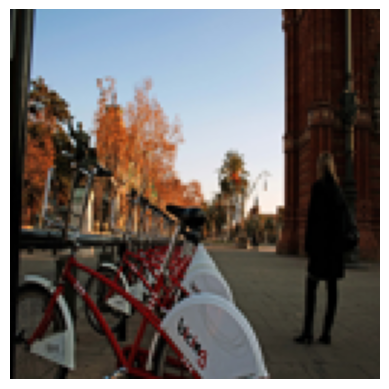

0 - a person is standing near a row of identical red and white bicycles
1 - a woman is standing outside near many bicycles
2 - a woman standing near a bike rack
3 - a woman stands near a row of identical red bicycles
4 - there is a row of red and white bikes all in a bike rack


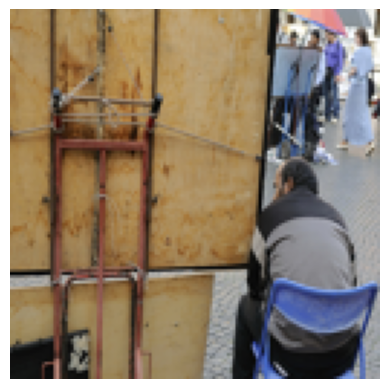

0 - a man sits behind two cardboard
1 - a man sitting in a blue metal chair
2 - a man sitting on a chair on the street next to a board
3 - man is sitting in a blue chair outside near large paintings
4 - man is sitting in blue chair next two pieces of wood


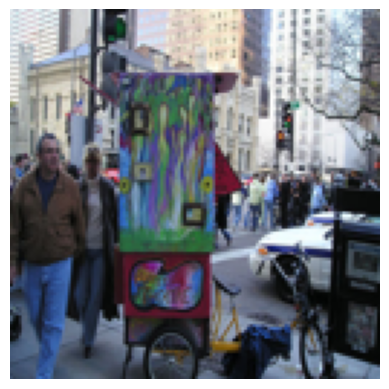

0 - a brightly decorated bicycle with cart with people walking around in the background
1 - a street machine is parked while people walk by
2 - a street vendor on the corner of a busy intersection
3 - people on the city street walk past a theater
4 - people walk around a mobile theater in a big city


In [4]:
def plot_random_image(images, captions):

    idx = np.random.randint(low=0, high=images.shape[0])

    im_plot = images[idx]
    plt.imshow(im_plot)
    plt.axis('Off')
    plt.show()

    for k, cap in enumerate(captions[idx]):
        print(k, '-', ' '.join(cap))

[plot_random_image(images, captions) for _ in range(3)];

# Preprocessing input data

### Extract Image Representation

Several pretrained convolutional neural networks exist that are capable of feature extraction from input images. We will load the pretrained *MobileNetV2* and use its pretrained convolutional layers to generate 'image codes' for each image in the array `images`. Such an image code is a compact representation of the input image. By using pretrained networks we get high-quality image codes while circumventing the need for training any convolutional layers.

First, we use the torchvision library to create an input pipeline that preprocesses the images to make them compatible with pretrained models. All pre-trained PyTorch models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W). The images are first transformed to PIL images in to range of [0, 1] and are then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].


We will provide some additional details regarding the implementation. In order to save some RAM (and reduce troubles with Colab running out of resources), we process the images in batches, as the GPU won't be able to process all 8091 images in parallel. We use PyTorch `DataLoaders` to take care of the batching. We also preprocess the data in batches. Doing so, we convert only the batches into single precision, and keep the *images* in their original format (uint8). Finally, we use the pretrained model to produce the image codes.

In [5]:
import torchvision #!pip install torchvision
from torchvision import transforms

def preprocess_batch(input_batch):
    # define preprocessing pipeline and apply preprocessing
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return torch.stack([preprocess(im) for im in input_batch], dim=0)

In [6]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model loaded on device: {device}")

# load pre-trained Mobilenet V2

# uncomment this line to first download mobilenet_v2 pretrained weights
# mobilenet = torch.hub.load('pytorch/vision', 'mobilenet_v2', force_reload=True, pretrained=True)
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)

#uncomment for a table-style description of the pretrained model
# from torchsummary import summary
# print(summary(convnet, input_size=(3,128,128), device=str(device)))

# remove last layer, use only the convolutional feature extractor
convnet = mobilenet.features.to(device)
convnet.eval()

image_codes = []
images = np.moveaxis(images, 3, 1)
for input_batch in tqdm(DataLoader(images, batch_size=64)):

    input_batch = preprocess_batch(input_batch)

    with torch.no_grad():
        output = convnet(input_batch.to(device)).cpu()

    image_codes.append(output)

image_codes = torch.cat(image_codes).flatten(start_dim=1)

print(f"Image codes shape: {image_codes.shape}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Model loaded on device: cuda


100%|██████████| 13.6M/13.6M [00:00<00:00, 130MB/s]


  0%|          | 0/127 [00:00<?, ?it/s]

Image codes shape: torch.Size([8091, 20480])


### Preprocess textual caption data

First, we create a list that lets us easily iterate over all 5 descriptions per image, i.e. we flatten the first and second axis of the `captions` list. As before, we leverage a Counter object to count the number of occurances of each token to finally create a vocabulary. Note that a tokenizer is not needed since the caption data already came as lists of tokens. The vocabulary is then created from the Counter object. Futhermore, we add a special token: <<l>_> to signal the model that the end of the sentence has been reached.

In [7]:
from collections import Counter
from torchtext.vocab import vocab, GloVe
import torchtext
torchtext.disable_torchtext_deprecation_warning()

# flatten the 5 descriptions for each of the 8091 samples
flat_captions = [cap for five_descriptions in captions for cap in five_descriptions]

counter = Counter()
for description_list in flat_captions:

    # count all words in sentence
    counter.update(description_list)

# create vocabulary
vocab = vocab(counter, min_freq=1,
              specials=['_'], special_first=True)

vectors_url = "https://drive.google.com/uc?id=1GfZXm6mmcyIseNECgggGFPW66ngaIM3N"
# Download vectors
gdown.download(vectors_url, "pretrained_vectors.pt", quiet=False)
pretrained_vectors = torch.load('pretrained_vectors.pt')

# downloading GloVe pretrained word embedding vectors takes long, so we directly download them
# pretrained_vectors = GloVe(name='6B', dim=300)
# pretrained_vectors = pretrained_vectors.get_vecs_by_tokens(vocab.get_itos())
#pretrained_vectors = pretrained_vectors.to(device)

/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
Downloading...
From: https://drive.google.com/uc?id=1GfZXm6mmcyIseNECgggGFPW66ngaIM3N
To: /content/pretrained_vectors.pt
100%|██████████| 3.59M/3.59M [00:00<

### Train/Validation/Test Split

In [8]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]

The vocabulary allows us to convert a list of tokens into integers:

    [vocab[token] for token in ['here', 'is', 'an', 'example']]
    >>> [476, 22, 31, 5298]

### Generate batch iterators

We create an input pipeline that generates batches of image codes (dense representations of the original image) and annoted descriptions of these images. This time, we construct a PyTorch `DataLoader` from a `TensorDataset`. The latter combines a tensor containing all inputs (image codes) and another tensor containing the targets (captions). To convert the captions into tensor format we again flatten the first two axes, resulting in a list of 5x8091=40455 captions. The first set of 5 descriptions in this list correspond to the first image, the second set of 5 descriptions correspond to the second image, etc. To create input/output pairs we duplicate each image code 4 times. In this way, the dataset contains 5 datapoints for each image code. To transform the lists of tokens into the desired tensor, we ensure that each sentence contains the same amount of tokens by padding sentences with the <<l>stop> token.

In [9]:
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

def convert_data(images, image_codes, captions):

    # repeat image codes, such that the same image code passes 5 times for each of the 5 caption descriptions
    duplicate_codes = torch.repeat_interleave(image_codes, repeats=5, dim=0)
    duplicate_imgs = torch.repeat_interleave(torch.tensor(images), repeats=5, dim=0)

    # flatten the 5 descriptions for each of the image codes
    flat_captions = [cap for five_descriptions in captions for cap in five_descriptions]

    # retrieve indices of words
    word_idcs = [torch.tensor(vocab.lookup_indices(cap), dtype=torch.long) for cap in flat_captions]

    # pad sequences to length of longest sequence in batch
    labels = pad_sequence(word_idcs, batch_first=True, padding_value=vocab['_'])


    return duplicate_imgs, duplicate_codes, labels

train_imgs, train_x, train_y = convert_data(train_images, train_codes, train_captions)
val_imgs, val_x, val_y = convert_data(val_images, val_codes, val_captions)
test_imgs, test_x, test_y = convert_data(test_images, test_codes, test_captions)

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"val_x shape: {val_x.shape}")
print(f"val_y shape: {val_y.shape}")
print(f"test_x shape: {val_x.shape}")
print(f"test_y shape: {val_y.shape}")


train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

train_x shape: torch.Size([30455, 20480])
train_y shape: torch.Size([30455, 32])
val_x shape: torch.Size([5000, 20480])
val_y shape: torch.Size([5000, 33])
test_x shape: torch.Size([5000, 20480])
test_y shape: torch.Size([5000, 33])


### Show images from train set

Below we provide a simple function that shows a random datapoint and its corresponding description (converted back from tokens to words), to give an idea of the inputs:outputs that are passed to the model while training.

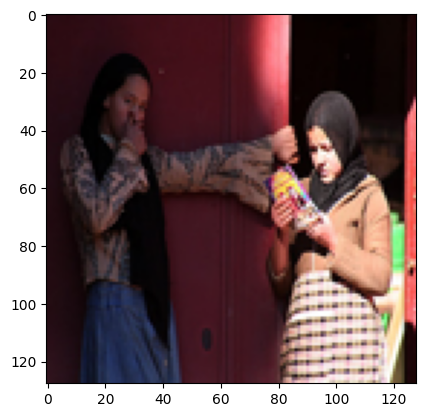

['two', 'girls', 'stand', 'up', 'against', 'a', 'red', 'wall', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


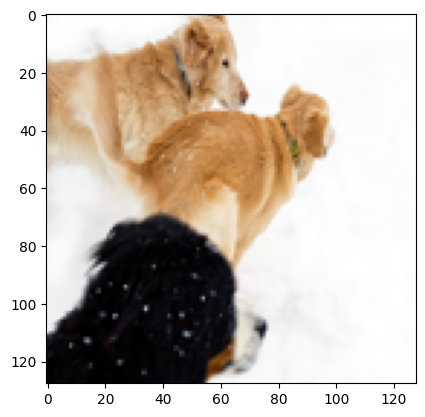

['three', 'dogs', 'are', 'in', 'the', 'snow', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


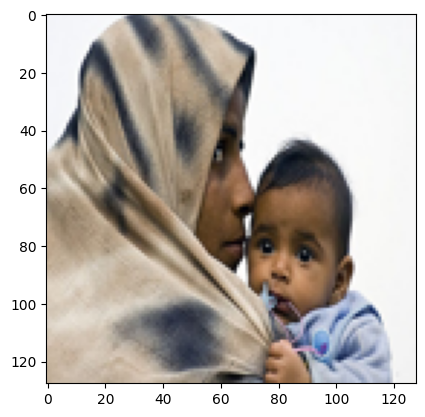

['a', 'woman', 'in', 'a', 'headdress', 'is', 'holding', 'a', 'little', 'boy', 'wearing', 'blue', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


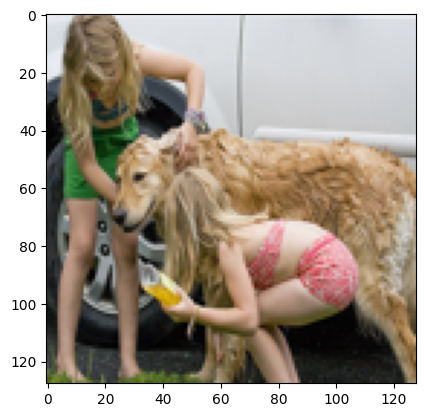

['a', 'dog', 'is', 'being', 'by', 'two', 'little', 'girls', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


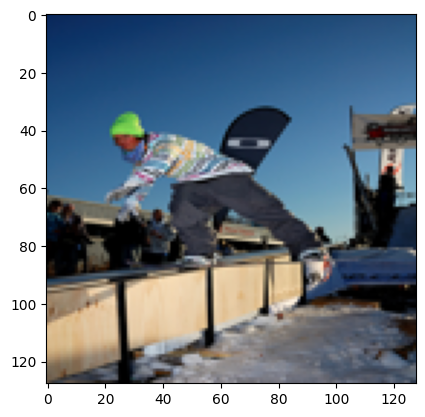

['a', 'snowboarder', 'wearing', 'a', 'green', 'hat', 'is', 'riding', 'along', 'a', 'metal', 'railing', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


In [10]:
def show_random_image_and_captions(images, labels):

    idx = np.random.randint(0, train_imgs.shape[0])

    plt.imshow(np.einsum('cyx->yxc', train_imgs[idx])) # reshape our image to allow plotting
    plt.show()

    lbl_cap = [vocab.get_itos()[word_idx] for word_idx in train_y[idx]]

    print(lbl_cap)


[show_random_image_and_captions(train_imgs, train_y) for _ in range(5)];

# Formal problem formulation

Before creating the model, we first formally introduce the learning problem. The approach of [1] for the task of generating sentences $S$ describing the image $I$ amounts to maximization of the likelihood w.r.t. to the model parameters, i.e.

$$
\theta^* = \underset{\theta}{\operatorname{argmax}} \sum_{(I,S)} \log P(S|I;\theta) \quad{(1)}
$$

Since $S$ represents any sentence, its length $N$ is unbounded and not strictly equal for all sentences. The joint probability over all tokens $S_0 , . . . , S_N$ that makes up the full sentence factorizes as follows


$$
\log p(S|I) = \sum_{t=0}^N\log{p(S_t|I, S_{0},..., S_{t-1})} \quad{(2)}
$$

At training time, we use data pairs $(I, S)$ to optimize the sum of probabilities, as described in (2). We model $p(S_t|I, S_{0},..., S_{t-1})$ with a Recurrent Neural Network (RNN), where the variable number of words we condition upon up to $t − 1$ is expressed by a fixed length hidden state $h_t$. This memory is updated after seeing a new input $x_t$ by using a non-linear function $f$:

$$
h_{t+1} =f(h_t,x_t) \quad{(3)}
$$

Note that we first insert the image. Thereafter, for $t=0$, we insert a start of sequence input $S_0$. For $t>0$, we have $x_t=S_t$. An overview of this process is as below (taken from [1], note that the RNN is implemented as LSTM):

<div>
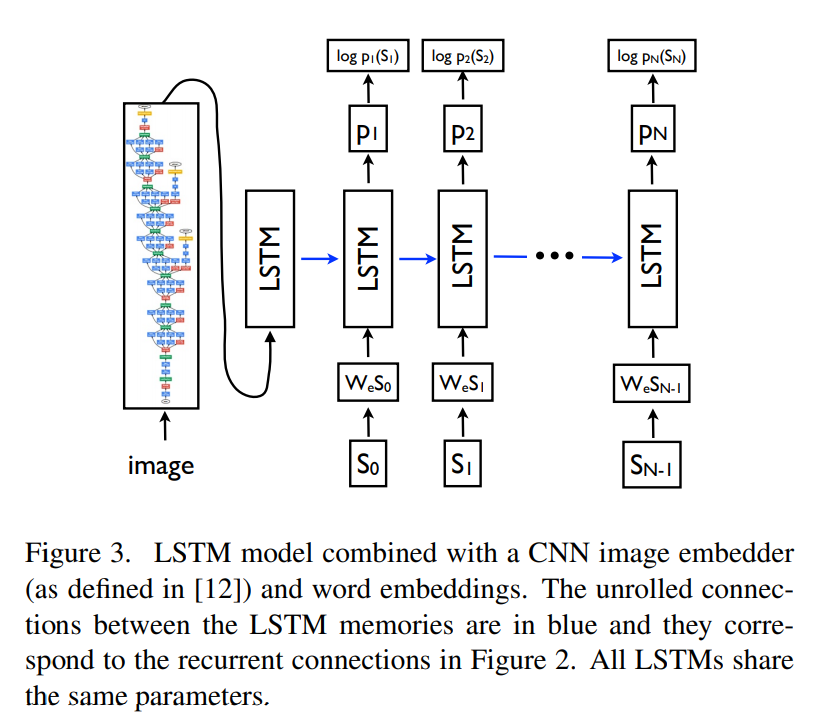
</div>

# Training  
In PyTorch we implement this model as follows. As always, first create a class which inherits from `nn.Module`. The initialization consists of declaring all model layers that will be used in the model's forward pass, the loss function and the optimizer.

### Model output & loss function

It is often instructive to think about what the output of a model should be. We aim at parametrizing each of the terms in the factorization of $P(S|x)$, i.e. the model output will be $p(S_t|I, S_{0},..., S_{t-1})$ at each $t$. Operationally, the output of the model will therefore be a matrix $P\in\mathbb{R}^{N\times V}$ containing for each of the $V$ words in the vocabulary the probability at each position unrolled step $t$ of the recurrent cell. In other words, the output is the concatenation of the probability distributions over all possible tokens for every position in the sentence. This machine learning task is sometimes described as a multiclass-classification task for each of the positions in the sentence. In PyTorch, models for multiclass-classification are optimized using `nn.CrossEntropyLoss()` criterion, as declared in the cell below.

### The recurrent procedure

With the aforementioned output and loss criterion, the model is trained to predict each word of the sentence after it has seen the image as well as all preceding words as defined by $p(S_t|I, S_0, . . . , S_{t−1})$. For this purpose, it is instructive to think of the RNN in unrolled form, as seen in the figure above. In more detail, if we denote by $I$ the input image and by $S = (S_1,...,S_N)$ a true sentence describing this image, the unrolling procedure is as follows:
1. First, we initialize the RNN's hidden and cell states as zero vectors and update them using the image $I$, i.e. $h_{t+1} = f(h_t, x_t=I)$
2. At $t=0$, we take the RNN cell and update it by inserting a start symbol $S_0$. In our case, we use a word embedding of all 0s as this symbol, i.e. $h_{t+1} = f(h_t, x_t=S_0)$
3. At all $t>0$, we (repeatedly) take the RNN cell and update it using the token $S_t$, i.e. $h_{t+1} = f(h_t, x_t=S_t)$

To make the above RNN more concrete two crucial design choices are made: which type of RNN and how the images and words are fed as inputs $x_t$. For the former we will use a Long short-term memory (LSTM) unit. The latter is a bit more involved to discuss, and works as follows.

During preprocessing, we encoded input images into a fixed size vector $\mathbb{R}^m$ by employing the pretrained convolutional layers of MobilenetV2. Similarly, we employ a word embedding layer which encodes each token index to vector representation $\mathbb{R}^k$. The RNN takes as input either the representation of $I$ *or* $S_t$. We choose to take the input size of $S_t$, and as such must convert the $I$-embeddings to this shape. To do so, we use dense layer $image\_emb$ which maps the image embedding vector to the same length as the word embedding, i.e. $image\_emb: \mathbb{R}^m \rightarrow \mathbb{R}^k$. Operationally, we concatenate all the different inputs to one tensor: the reshaped $I$, the starting 'symbol' $S_0$ and the ground-truth caption $S_t$. This creates a tensor of shape (`batch_size`, `max_seq_len_in_batch`, $k$). PyTorch's RNN takes as input the concatenation of these embeddings. Under the hood, it initiates a hidden state of zeros (by default) and automatically updates the hidden state after seeing the (word) embedding in the sequence.

The RNN output considers a tensor containing the output at each (unrolled) timestep (alongside its hidden state, which we do not use for word prediction). For each unrolled timestep, we map this output to a probability distribution over all words. We use an additional dense layer to allow for the model to learn more complex relations. As such, the RNN output is first fed through dense layer $f_0$, after which it goes through dense layer $f_1$, which outputs the probability distribution over all words.

Note that to map the output of $f_1$ to a probability distribution we would normally apply a softmax function. In this implementation this softmax function is applied by PyTorch's computation of categorical cross-entropy, and as such we do not explicitely apply it.


In [11]:
print(f"Neural Code length: {train_codes.shape[1]}")
print(f"Max caption length: {max((train_y.shape[-1],val_y.shape[-1]))}")
print(f"Embedding dim: {pretrained_vectors.shape[1]}")
print(f"Number of words: {pretrained_vectors.shape[0]-1}")

Neural Code length: 20480
Max caption length: 33
Embedding dim: 300
Number of words: 2991


In [12]:
from torch import nn

class TrainCaptionGenerator(nn.Module):

    def __init__(self,
                 vocab = vocab,
                 code_length=image_codes.shape[1],
                 embedding_dim=pretrained_vectors.shape[1],
                 hidden_dim=512,
                 hidden_dense_dim=512,
                 dense_dropout=0.4):

        super(TrainCaptionGenerator, self).__init__()

        # Save some parameters inside this object
        self.vocab = vocab
        self.code_length = code_length
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Embed image from 20480 to embedding_dim
        self.image_emb = nn.Linear(code_length, self.embedding_dim) #(batch_size, embedding_dim)

        self.word_embeddings = nn.Embedding(len(vocab), embedding_dim)

        # Process data with LSTM
        self.rnn = nn.LSTM(self.embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Fully connected layer after RNN output, to learn more complex relations
        self.f0 = nn.Linear(hidden_dim, hidden_dense_dim)
        self.relu = nn.ReLU()

        # Dropout to regularize this dense layer
        self.drop = nn.Dropout(p=dense_dropout)

        # Map to a categorical distribution of length num_words
        self.f1 = nn.Linear(hidden_dense_dim, len(vocab))

        # Loss function
        # PyTorch applies softmax in CrossEntropyLoss, so we do not need to add it ourselves
        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, image_codes, padded_word_idcs):
        """
        Forward pass of trainable model. It predicts each next word
        in the descriptive sentence as if the previous word was correct
        by substitution of the ground truth word for the previous word.

        Input:
        image_codes shape: (batch_size, 20480)
        padded_word_idcs shape: (batch_size, max_seq_len_in_batch)

        Outputs:
        output: (batch_size, max_seq_len_in_batch, num_words)

        Softmax activation on top of the output matrix yields
        a probability distribution (probability mass function) over each of the vocabulary words
        for each word in a sequence of length max_seq_len_in_batch.
        The final predicted sentence can be constructed from this pmf.
        """

        # retrieve word embedding vectors from the token indices
        caption_vectors = pretrained_vectors[padded_word_idcs.cpu()].to(image_codes.device) #(batch_size, max_seq_len_in_batch, embedding_dim)

        # we remove the last timestep, as we do not take the final word as input
        # for a 'next' word (since the sequence has ended)
        caption_vectors = caption_vectors[:, :-1,:]

        # as initial input / start 'symbol' we use a word embedding of all 0s
        batch_size = caption_vectors.size()[0]
        embedding_dim = caption_vectors.size()[2]
        zeros = torch.zeros((batch_size, 1, embedding_dim)).to(image_codes.device) #(batch_size, 1, embedding_dim)

        # Embed image from 20480 to embedding_dim and reshape as necessary
        image_vector = self.image_emb(image_codes) #(batch_size, embedding_dim)
        image_vector = image_vector.unsqueeze(1) #(batch_size, 1, embedding_dim)

        # Concatenate all our inputs -> the image, the 'start symbol' and the caption embedding vectors
        concat_embeddings = torch.cat([image_vector, zeros, caption_vectors], dim=1) #(batch_size, max_seq_len_in_batch+1, embedding_dim)

        # Feed packed input sequence to rnnn
        rnn_output, rnn_state = self.rnn(concat_embeddings)  #(batch_size, max_seq_len_in_batch+1, embedding_dim)

        # To further process, put the data through a dense layer
        output = self.f0(rnn_output)

        # apply activation
        output = self.relu(output)

        # and apply dropout!
        output = self.drop(output)

        # Map rnn output to vector of length num_words
        output = self.f1(output) #(batch_size, max_seq_len_in_batch+1, num_words)

        # we remove the first output as it corresponds to the 'input image'
        # being inserted --> from 1 onwards we process words
        output = output[:, 1:] #(batch_size, max_seq_len_in_batch, num_words)
        return output


### Training/evaluation loop

The training and evaluation loop is similar to that of P3.1. However, there is a slight difference: we compute accuracies in terms of each token in the sentence whereas in P3.1 it was sufficient to calculate accuracy over a single prediction (the genre of a news article).

In [13]:
import time

def train(dataloader):

    joint_probability_model.train()

    total_correct, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (image_codes, padded_word_idcs) in enumerate(dataloader):

        image_codes = image_codes.to(device)
        padded_word_idcs = padded_word_idcs.to(device)

        joint_probability_model.optimizer.zero_grad()

        y_pred = joint_probability_model(image_codes, padded_word_idcs)

        # predictions for nn.CrossEntropyLoss should have shape (batch_size, num_classes, max_len)
        loss = joint_probability_model.criterion(y_pred.permute((0,2,1)), padded_word_idcs)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(joint_probability_model.parameters(), 0.1)

        joint_probability_model.optimizer.step()

        total_correct += (y_pred.argmax(2) == padded_word_idcs).sum().item()
        total_count += padded_word_idcs.size(0) * 35


        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_correct/total_count))
            total_correct, total_count = 0, 0
            start_time = time.time()

    return total_correct/total_count

def evaluate(dataloader):
    joint_probability_model.eval()
    total_correct, total_count = 0, 0

    with torch.no_grad():
        for idx, (image_codes, padded_word_idcs) in enumerate(dataloader):

            image_codes = image_codes.to(device)
            padded_word_idcs = padded_word_idcs.to(device)

            y_pred = joint_probability_model(image_codes, padded_word_idcs)

            loss = joint_probability_model.criterion(y_pred.permute((0,2,1)), padded_word_idcs)

            total_correct += (y_pred.argmax(2) == padded_word_idcs).sum().item()
            total_count += padded_word_idcs.size(0) * 35

    return total_correct/total_count

In [14]:
# hyperparameters
EPOCHS = 25

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initiate recurrent classification model
joint_probability_model = TrainCaptionGenerator().to(device)

train_acc, val_acc = [], []
# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_acc.append(train(train_dataloader))
    val_acc.append(evaluate(val_dataloader))

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train accuracy {:8.3f} '
          'validation accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_acc[-1],
                                           val_acc[-1]))
    print('-' * 59)




-----------------------------------------------------------
| end of epoch   1 | time: 11.62s | train accuracy    0.673 validation accuracy    0.720 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time: 10.93s | train accuracy    0.699 validation accuracy    0.728 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time: 11.42s | train accuracy    0.706 validation accuracy    0.732 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time: 11.18s | train accuracy    0.710 validation accuracy    0.734 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time: 11.26s | train accuracy    0.713 validation accuracy    0.736 
----------

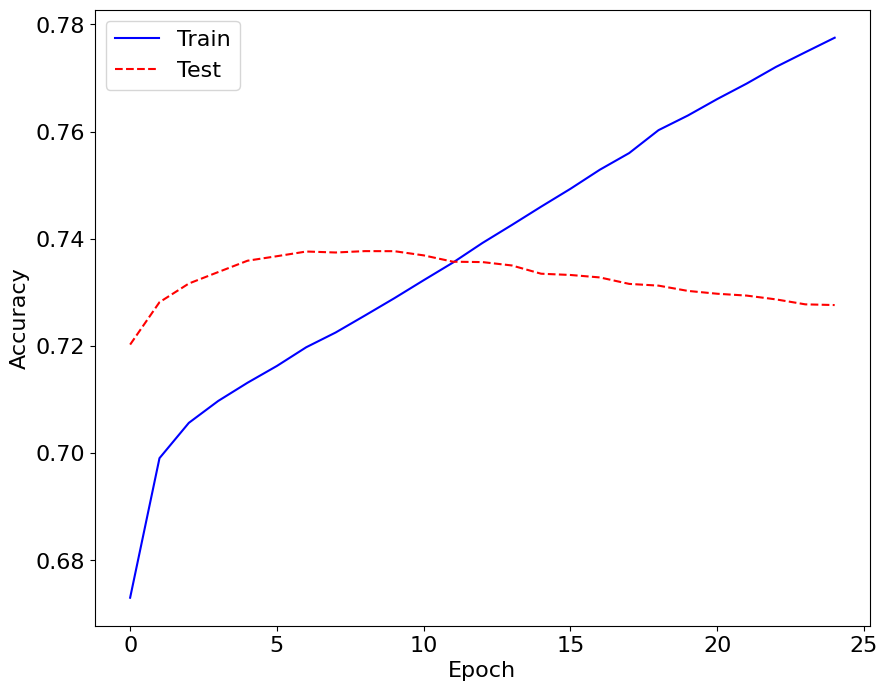

In [15]:
f, ax = plt.subplots(1,1, figsize=(10,8))


fnt=16
ax.plot(train_acc, color='blue', label='Train')
ax.plot(val_acc, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Accuracy", fontsize=fnt);

# Inference

The trained model parametrizes the joint probability distribution $P(S|I)$ of a sentence describing an image. Formally, we seek the sentence $S$ which maximizes $P(S|I)$, i.e.

$$
S = \underset{S^{'}}{\operatorname{argmax}} p(S^{′}|I). \quad{(4)}
$$

There are multiple approaches that can be used to generate a sentence given such a distribution $P(S|I)$.

### Greedy decoder
The first approach is to compute the sentence by, for each timestep, taking the word with the highest probability. We sample the first word by inserting image $I$ and start-token $S_0$ and taking the word with the highest probability, after which we sample each subsequent word by inserting the previously selected word and again taking the most likely word. We continue this process until the special end-of-sentence token or the maximum sequence length is reached. This approach is implemented below.

In [16]:
class GreedyImageCaptionDecoder():

    def __init__(self,
                 joint_probability_model = joint_probability_model,
                 max_caption_length = 35):

        self.trained_model = joint_probability_model
        self.max_caption_length = max_caption_length

    def decode(self, image_codes):

        self.trained_model.train()

        with torch.no_grad():
            # Embed image from 20480 to embedding_dim
            image_vector = self.trained_model.image_emb(image_codes) #(batch_size, embedding_dim)
            image_vector = image_vector.unsqueeze(1) #(batch_size, 1, embedding_dim)

            # take our rnn cell in eval-mode: in case we use multiple layers with
            # dropout (not currently selected), we want to avoid using dropout in
            # the evaluation -> .eval() fixes this
            rnn_eval = self.trained_model.rnn.eval()

            # sample the initial hidden state using the image vector
            rnn_output_initial, rnn_state = rnn_eval(input=image_vector, hx=None)  #(batch_size, 1, embedding_dim)


            captions_idx = []
            # Manually unroll model, output of step t-1 is input of RNN in step t
            for t in range(0, self.max_caption_length):
                if t == 0:
                    # for the starting symbol, we use a word embedding of all 0s
                    batch_size = rnn_output_initial.size()[0]
                    embedding_size = pretrained_vectors.size()[1]
                    caption_vectors = torch.zeros((batch_size, 1, embedding_size))
                else:
                    # if we are further along, take the embedding of the previously predicted word
                    caption_vectors = pretrained_vectors[captions_idx[-1].cpu()]

                # Feed embedding of previous word into RNN
                rnn_output_next_word, rnn_state = rnn_eval(input=caption_vectors.to(device),
                                                                        hx=rnn_state)  #(batch_size, 1, embedding_dim)
                # feed output through dense
                rnn_output_next_word = self.trained_model.f0(rnn_output_next_word)
                rnn_output_next_word = self.trained_model.relu(rnn_output_next_word)

                # Map to num_words entries which enables predicting next word of sentence
                pmf_next_word = self.trained_model.f1(rnn_output_next_word) #(batch_size, 1, num_words)

                # Obtain idx of next word by selecting idx of word with highest probability
                # (note that softmax is not used in our case, however argmax is same before/after softmax)
                idx_next_word = pmf_next_word.argmax(dim=2) #(batch_size, 1)

                # append next word idcs to caption list
                captions_idx.append(idx_next_word)


            # list to numpy format by stacking words of each sentence
            captions_idx = torch.stack(captions_idx, dim=1)\
                                .flatten(start_dim=1, end_dim=2)\
                                .detach().cpu().numpy()

            # retrieve words of each idx and compose words of sentences
            caption_words = np.array(self.trained_model.vocab.get_itos())[captions_idx]

            # remove stop words
            predicted_captions = [[word for word in cap if word != vocab['_']] for cap in caption_words]

            return predicted_captions

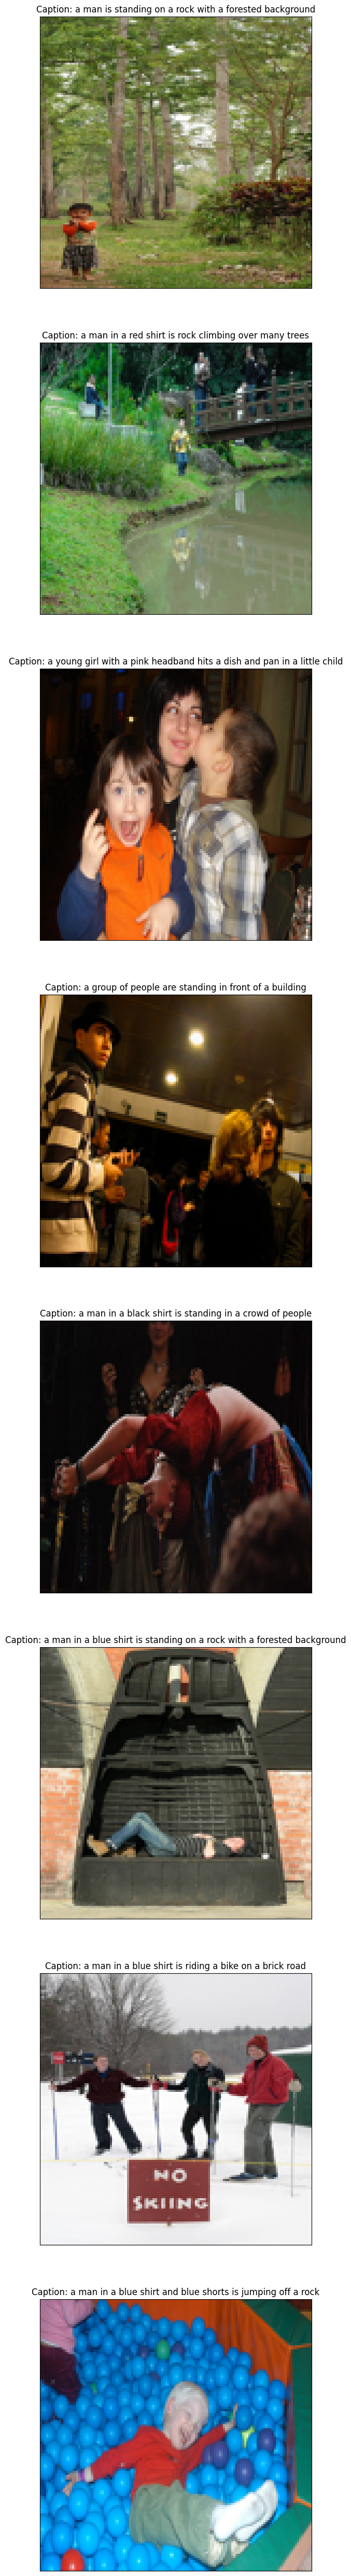

In [17]:

nrows = 8; ncols = 1; s=8

decoder = GreedyImageCaptionDecoder(joint_probability_model)
predicted_captions = decoder.decode(test_codes.to(device))

# initiate subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*s, nrows*s))
np.random.seed(6)
im_idcs = np.random.randint(low=0, high = len(test_images), size=nrows*ncols)

list_to_str = lambda captionList: " ".join(str(x) for x in captionList)

i = 0
# plot examples
for ax in axes:

    ax.imshow(np.einsum('cyx->yxc', test_images[im_idcs[i]])) # reshape our image to allow plotting
    ax.set_xticks([]); ax.set_yticks([])

    list_of_tokens = predicted_captions[im_idcs[i]]
    caption = list_to_str([tok for tok in list_of_tokens if tok != '_'])

    ax.set_title(f"Caption: {caption}", fontsize=12)
    i += 1

### BeamSearch decoder
Another approach for generating a sentence from $P(S|I)$ is BeamSearch: iteratively consider the set of the $k$ best sentences up to time $t$ as candidates to generate sentences of size $t + 1$, and keep only the resulting best $k$ of them. This better approximates (4), BeamSearch is expected to increase performance (BeamSearch with $k=1$ is equivalent to the greedy decoder as implemented above). The implementation is left as an exercise. For more details on BeamSearch, we refer to section 5.3.3 of the lecture notes (pg. 99).

# Discussion

As is evident from the accuracy plot, the model overfits on the training set: After epoch ~10 the validation accuracy does not increase further, whereas the training accuracy does. To overcome this issue one can try multiple approaches, for example changing the number of (dense or recurrent) layers or changing their respective dimensions.